In [1]:
# Bringing data [Motaz]
# Hyper parameter optamization [Omar]
# Save model in TensorFlow Lite [Omar]
# Regularization (Drop Out) [Motaz]
# Regularization (early stopping) [Motaz]
# different optimization algorithms [Motaz]
# Figuring optamization methods [Meqdad]
# Mobile Application template [Meqdad]

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras

from keras.callbacks import EarlyStopping
from keras.layers.core import Dropout

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random

print(tf.__version__)

2.8.0


The MNIST database contains 60,000 training images and 10,000 testing images of handwritten digits. We will use the dataset to train our digit classification model.

Each image in the MNIST dataset is a 28x28 grayscale image containing a digit from 0 to 9, and a label identifying which digit is in the image.

In [21]:
# Keras provides a handy API to download the MNIST dataset, and split them into
# "train" dataset and "test" dataset.
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

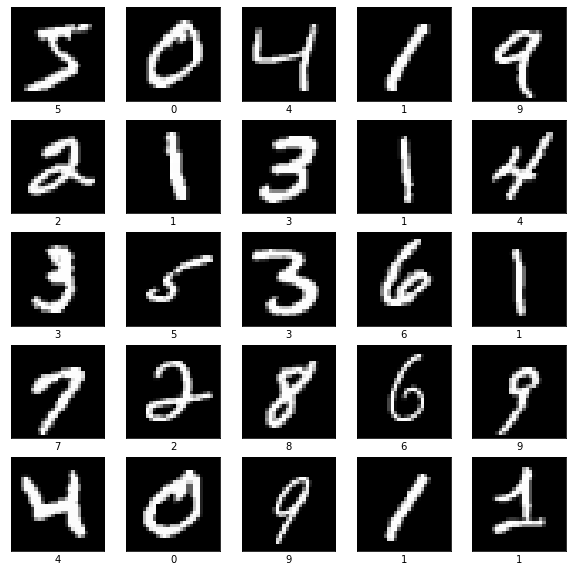

In [6]:
# Show the first 25 images in the training dataset.
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

In [23]:
train_images[0].shape # 28px x 28px grayscale image

(28, 28)

In [24]:
train_images = train_images.astype("float") / 225.0 # Normalizing the training data
test_images = test_images.astype("float") / 225.0 # Normalizing the testing data

In [10]:
first_model = keras.models.Sequential([ # build simple model and see accuracy
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation = "relu", name = "layer1"),
        keras.layers.Dense(128, activation = "relu", name = "layer2"),
        keras.layers.Dense(128, activation = "relu", name = "layer3"),
        keras.layers.Dense(128, activation = "relu", name = "layer4"),
        
        keras.layers.Dense(10, activation='softmax', name = "output"),
])

first_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
first_model.fit(train_images, train_labels, 
          epochs = 10, 
          batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2313 - accuracy: 0.9310
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1127 - accuracy: 0.9655
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0842 - accuracy: 0.9736
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0694 - accuracy: 0.9792
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0611 - accuracy: 0.9817
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0494 - accuracy: 0.9847
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0447 - accuracy: 0.9863
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0409 - accuracy: 0.9874
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0355 - accuracy: 0.9898
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.

In [12]:
model1_eval = first_model.evaluate(test_images, test_labels, return_dict=True)

313/313 [==============================] - 1s 2ms/step - loss: 0.1313 - accuracy: 0.9735


In [25]:
def model_builder(hp: kt.HyperParameters) -> keras.models.Sequential:
    """function that take HyperParameters object to make diffreant values for hyperparameter optimization

    Args:
        hp (kt.HyperParameters): object contean function that allwod to make diffreant values

    Returns:
        _type_: keras.models.Sequential
    """
    hp_units = hp.Int('units', min_value=128, max_value=512, step=32)
    hp_optimizer = hp.Choice('optimizer', values=['adam','adamax'])
    activations=hp.Choice("activation", ["relu", "tanh"])

    model_hp = keras.models.Sequential([
                                    
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(units=hp_units, activation =activations, name = "layer1"),
    Dropout(0.25),
    keras.layers.Dense(units=hp_units, activation =activations, name = "layer2"),
    Dropout(0.25),
    keras.layers.Dense(units=hp_units, activation =activations, name = "layer3"),
    Dropout(0.25),
    keras.layers.Dense(units=hp_units, activation =activations, name = "layer4"),
    Dropout(0.25),
    
    keras.layers.Dense(10, activation='softmax', name = "output"),
    ])

    model_hp.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=hp_optimizer, 
                    metrics=['accuracy'])
    
    return model_hp



In [26]:
tuner = kt.RandomSearch(
    hypermodel=model_builder,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=3,
    overwrite=True,
    project_name="khyperband",
)

In [27]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 32, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'adamax'], 'ordered': False}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}


In [28]:
x_train = train_images[:-10000]
x_val = train_images[-10000:]
y_train = train_labels[:-10000]
y_val = train_labels[-10000:]

split data to train and validation 

In [29]:
tuner.search(x_train, y_train, 
             epochs=10, 
             validation_data=(x_val, y_val),
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=3)])

Trial 10 Complete [00h 08m 01s]
val_accuracy: 0.975000003973643

Best val_accuracy So Far: 0.9815333485603333
Total elapsed time: 01h 29m 55s
INFO:tensorflow:Oracle triggered exit


In [30]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]

take the best model

In [34]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 layer1 (Dense)              (None, 448)               351680    
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 layer2 (Dense)              (None, 448)               201152    
                                                                 
 dropout_1 (Dropout)         (None, 448)               0         
                                                                 
 layer3 (Dense)              (None, 448)               201152    
                                                                 
 dropout_2 (Dropout)         (None, 448)               0

In [31]:
best_model.evaluate(test_images, test_labels, return_dict=True)

313/313 [==============================] - 2s 5ms/step - loss: 0.0634 - accuracy: 0.9840


{'accuracy': 0.984000027179718, 'loss': 0.06342479586601257}

good accuracy and loss

In [32]:
model1_eval

{'accuracy': 0.9735000133514404, 'loss': 0.13132120668888092}

In [33]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Save the model.
with open('detect.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp7v9mvlsp/assets
